In [422]:
#!pip install --upgrade pandas
#!pip install --upgrade scikit-learn
#pip install --upgrade scipy
#!pip install --upgrade matplotlib
#!pip install --upgrade xgboost

import pandas as pd
import numpy as np

from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score,roc_curve

import matplotlib.pyplot as plt


# Load Data

## Load play data

In [2]:
schema = StructType([StructField("uid", StringType(), True), 
                     StructField('device', StringType(), True),
                     StructField('song_id', StringType(), True),
                     StructField('song_type', StringType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('play_time', StringType(), True),
                     StructField('song_length', StringType(), True),
                     StructField('paid_flag', StringType(), True),
                     StructField('file_name', StringType(), True)])
# note: the data type should be the right type. First, I change the types and it doesn't work.

In [3]:
df = sqlContext.read.format("com.databricks.spark.csv")\
         .options(delimiter="\t").schema(schema)\
         .options(header="false").load("gs://musix_box/all_play.log.fn")

In [5]:
# delete the extra space in each column
df = df.withColumn('uid', trim(df.uid))
df = df.withColumn('device', trim(df.device))
df = df.withColumn('song_id', trim(df.song_id))
df = df.withColumn('song_type', trim(df.song_type))
df = df.withColumn('song_name', trim(df.song_name))
df = df.withColumn('singer', trim(df.singer))
df = df.withColumn('play_time', trim(df.play_time))
df = df.withColumn('song_length', trim(df.song_length))
df = df.withColumn('paid_flag', trim(df.paid_flag))
df = df.withColumn('file_name', trim(df.file_name))

## Load Download Data

In [255]:
schema_down = StructType([StructField("uid", StringType(), True), 
                     StructField('device', StringType(), True),
                     StructField('song_id', StringType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('paid_flag', StringType(), True),
                     StructField('file_name', StringType(), True)])

In [256]:
df_down = sqlContext.read.format("com.databricks.spark.csv")\
         .options(delimiter="\t").schema(schema_down)\
         .options(header="false").load("gs://musix_box/all_down.log.fn")

In [257]:
# delete the extra space in each column
df_down = df_down.withColumn('uid', trim(df_down.uid))
df_down = df_down.withColumn('device', trim(df_down.device))
df_down = df_down.withColumn('song_id', trim(df_down.song_id))
df_down = df_down.withColumn('song_name', trim(df_down.song_name))
df_down = df_down.withColumn('singer', trim(df_down.singer))
df_down = df_down.withColumn('file_name', trim(df_down.file_name))

In [258]:
df_down.show()

+---------+------+-------+--------------------+-------------------+---------+-------------------+
|      uid|device|song_id|           song_name|             singer|paid_flag|          file_name|
+---------+------+-------+--------------------+-------------------+---------+-------------------+
|168019810|    ar| 442554|                 小酒窝|            林俊杰&蔡卓妍|       0 |20170330_1_down.log|
|168019810|    ar|6334611|                 社会摇|                 萧全|       0 |20170330_1_down.log|
|168019810|    ar|9867382|                  台阶|                 武艺|       0 |20170330_1_down.log|
|168019810|    ar|6660691| 一次就好-(电影《夏洛特烦恼》暖水曲)|                杨宗纬|       0 |20170330_1_down.log|
|168019810|    ar| 157606|               一路上有你|                张学友|       0 |20170330_1_down.log|
|168019810|    ar|3372481|        十年 (OT：明年今日)|                陈奕迅|       0 |20170330_1_down.log|
|168019810|    ar|3216525|       你不知道的事(Live版)|                王力宏|       0 |20170330_1_down.log|
|168019810|    ar|64

# Prepare Data

## Add Date Feature

In [7]:
# define get_date function
def get_date(file_name):
    tmp_list = str(file_name).split('_')
    return tmp_list[0]

example_udf = F.udf(get_date)


In [ ]:
# add date to play dataset
df_play = df.withColumn('date', example_udf(df.file_name))

In [9]:
# check types of df_play
df_play.dtypes

[('uid', 'string'),
 ('device', 'string'),
 ('song_id', 'string'),
 ('song_type', 'string'),
 ('song_name', 'string'),
 ('singer', 'string'),
 ('play_time', 'string'),
 ('song_length', 'string'),
 ('paid_flag', 'string'),
 ('file_name', 'string'),
 ('date', 'string')]

In [13]:
# convert features to right data types
df_play = df_play.withColumn('play_time', df_play['play_time'].cast('float'))
df_play = df_play.withColumn('song_length', df_play['song_length'].cast('float'))
df_play = df_play.withColumn('date', df_play['date'].cast('integer'))
df_play.dtypes

[('uid', 'string'),
 ('device', 'string'),
 ('song_id', 'string'),
 ('song_type', 'string'),
 ('song_name', 'string'),
 ('singer', 'string'),
 ('play_time', 'float'),
 ('song_length', 'float'),
 ('paid_flag', 'string'),
 ('file_name', 'string'),
 ('date', 'int')]

In [259]:
# add date to download dataset
df_down = df_down.withColumn('date', example_udf(df_down.file_name))
df_down.show()

+---------+------+-------+--------------------+-------------------+---------+-------------------+--------+
|      uid|device|song_id|           song_name|             singer|paid_flag|          file_name|    date|
+---------+------+-------+--------------------+-------------------+---------+-------------------+--------+
|168019810|    ar| 442554|                 小酒窝|            林俊杰&蔡卓妍|       0 |20170330_1_down.log|20170330|
|168019810|    ar|6334611|                 社会摇|                 萧全|       0 |20170330_1_down.log|20170330|
|168019810|    ar|9867382|                  台阶|                 武艺|       0 |20170330_1_down.log|20170330|
|168019810|    ar|6660691| 一次就好-(电影《夏洛特烦恼》暖水曲)|                杨宗纬|       0 |20170330_1_down.log|20170330|
|168019810|    ar| 157606|               一路上有你|                张学友|       0 |20170330_1_down.log|20170330|
|168019810|    ar|3372481|        十年 (OT：明年今日)|                陈奕迅|       0 |20170330_1_down.log|20170330|
|168019810|    ar|3216525|       你不知道

## Clean Data - exclude the extreme data

In [15]:
# select the 95% quantile of play_time and 99% quantile of song_length with 0.005 relativeError
extreme_play_time = df_play.approxQuantile("play_time", [0.95], 0.005)

In [16]:
extreme_song_length = df_play.approxQuantile("song_length", [0.99], 0.005)

In [17]:
extreme_play_time, extreme_song_length

([62694.0], [1386.0])

In [19]:
df_play_valid = df_play.filter((col('play_time') < extreme_play_time[0]) &\
                               (col('song_length') < extreme_song_length[0]) &\
                               (col('song_length') != 0))

In [20]:
# drop missing values
df_play_valid = df_play_valid.na.drop()

In [38]:
#df_play_valid.show()

+---------+------+--------+---------+--------------------+------+---------+-----------+---------+-------------------+--------+
|      uid|device| song_id|song_type|           song_name|singer|play_time|song_length|paid_flag|          file_name|    date|
+---------+------+--------+---------+--------------------+------+---------+-----------+---------+-------------------+--------+
|154824972|    ar| 3300104|        0|     Not A Love Song|  Bean|     22.0|      178.0|        0|20170302_1_play.log|20170302|
|154431666|    ar| 6651913|        0|             再见只是陌生人|   庄心妍|    252.0|      251.0|        0|20170302_1_play.log|20170302|
|154439430|    ar|20870987|        0|                  哥哥|    张杰|    358.0|      358.0|        0|20170302_1_play.log|20170302|
|154739280|    ar|  872687|        0|             苦酒一杯又一杯|   龙飘飘|    164.0|      165.0|        0|20170302_1_play.log|20170302|
|154777138|    ip| 9950164|        0|               刚好遇见你|   李玉刚|      0.0|      200.0|        0|20170302_1_pla

## Extract features

### Features from Play dataset

In [317]:
# recency feature: 20170501(test time) - the latest time the user play before 20170501 
df_recency = df_play_valid.filter((col('date') >= 20170329) & (col('date') <= 20170430)).groupBy("uid").agg(20170501 -max('date'))

In [319]:
# split the data into three period p1: (20170329,20170409); p2: (20170410,20170419), p3: (20170420, 20170429)

df_p1 = df_play_valid.filter((col('date') >= 20170329) & (col('date') < 20170409))
df_p2 = df_play_valid.filter((col('date') >= 20170409) & (col('date') < 20170420))
df_p3 = df_play_valid.filter((col('date') >= 20170420) & (col('date') <= 20170430))

# note: df_play.select('date') is dataframe, df_play.date is column.

In [31]:
# df_p1.count()
# 50M +

In [32]:
#df_p2.count()

29139947

In [320]:
# create the pipeline for data aggreation 
def pipeline(dataframe_list):
    output = []
    
    for idx, df in enumerate(dataframe_list):
        period_tag = "p%s" % (idx + 1)
        group_uid = df.groupBy("uid")
        df_agg = group_uid.agg(countDistinct('uid').alias(period_tag + '_play_freq'), 
                               countDistinct("song_name").alias(period_tag + '_song_num'), 
                               sum("play_time").alias(period_tag + '_play_time'), 
                               mean(df.play_time/df.song_length).alias(period_tag + '_play_perc'),
                               countDistinct("singer").alias(period_tag + '_singer_num'))
        output.append(df_agg)

    return output

In [321]:
# extract features for three periods
df_p1_whole, df_p2_whole, df_p3_whole = pipeline([df_p1,df_p2,df_p3])

In [16]:
#df_p1_whole.count()

519737

In [67]:
#df_p2_whole.count()

270507

In [19]:
#df_p3_whole.count()

In [322]:
df_p1_whole.dtypes

[('uid', 'string'),
 ('p1_play_freq', 'bigint'),
 ('p1_song_num', 'bigint'),
 ('p1_play_time', 'double'),
 ('p1_play_perc', 'double'),
 ('p1_singer_num', 'bigint')]

In [323]:
# join all features together
df_play_whole = df_p1_whole.join(df_p2_whole, 'uid', 'outer')

In [324]:
df_play_whole = df_play_whole.join(df_p3_whole, 'uid', 'outer')

In [325]:
df_play_whole = df_play_whole.join(df_recency, 'uid', 'left')

In [326]:
# change the feature name
df_play_whole = df_play_whole.withColumnRenamed("colName", "newColName").withColumnRenamed("(20170501 - max(date))", "recency")

In [327]:
df_play_whole.dtypes

[('uid', 'string'),
 ('p1_play_freq', 'bigint'),
 ('p1_song_num', 'bigint'),
 ('p1_play_time', 'double'),
 ('p1_play_perc', 'double'),
 ('p1_singer_num', 'bigint'),
 ('p2_play_freq', 'bigint'),
 ('p2_song_num', 'bigint'),
 ('p2_play_time', 'double'),
 ('p2_play_perc', 'double'),
 ('p2_singer_num', 'bigint'),
 ('p3_play_freq', 'bigint'),
 ('p3_song_num', 'bigint'),
 ('p3_play_time', 'double'),
 ('p3_play_perc', 'double'),
 ('p3_singer_num', 'bigint'),
 ('recency', 'int')]

In [328]:
# convert bigint to integer
df_play_whole = df_play_whole.withColumn('p1_play_freq', df_play_whole['p1_play_freq'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p1_song_num', df_play_whole['p1_song_num'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p1_singer_num', df_play_whole['p1_singer_num'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p2_play_freq', df_play_whole['p2_play_freq'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p2_song_num', df_play_whole['p2_song_num'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p2_singer_num', df_play_whole['p2_singer_num'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p3_play_freq', df_play_whole['p3_play_freq'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p3_song_num', df_play_whole['p3_song_num'].cast('integer'))
df_play_whole = df_play_whole.withColumn('p3_singer_num', df_play_whole['p3_singer_num'].cast('integer'))

In [329]:
df_play_whole.printSchema()

root
 |-- uid: string (nullable = true)
 |-- p1_play_freq: integer (nullable = true)
 |-- p1_song_num: integer (nullable = true)
 |-- p1_play_time: double (nullable = true)
 |-- p1_play_perc: double (nullable = true)
 |-- p1_singer_num: integer (nullable = true)
 |-- p2_play_freq: integer (nullable = true)
 |-- p2_song_num: integer (nullable = true)
 |-- p2_play_time: double (nullable = true)
 |-- p2_play_perc: double (nullable = true)
 |-- p2_singer_num: integer (nullable = true)
 |-- p3_play_freq: integer (nullable = true)
 |-- p3_song_num: integer (nullable = true)
 |-- p3_play_time: double (nullable = true)
 |-- p3_play_perc: double (nullable = true)
 |-- p3_singer_num: integer (nullable = true)
 |-- recency: integer (nullable = true)



In [51]:
# df_play_whole.count() # 567K+

Therefore, after dropping outliers and aggregation, we now have 567k rows of data.

### Features from Download Dataset

In [331]:
# split into three periods
df_down_p1 = df_down.filter((col('date') >= 20170329) & (col('date') < 20170409))
df_down_p2 = df_down.filter((col('date') >= 20170409) & (col('date') < 20170420))
df_down_p3 = df_down.filter((col('date') >= 20170420) & (col('date') <= 20170430))

In [332]:
# create features
def down_pipeline(dataframe_list):
    output = []
    
    for idx, df in enumerate(dataframe_list):
        period_tag = "p%s" % (idx + 1)
        group_uid = df.groupBy("uid")
        df_agg = group_uid.agg(countDistinct('uid').alias(period_tag + '_down_freq'))
        output.append(df_agg)

    return output

In [333]:
# extract features for three periods
down_p1, down_p2, down_p3 = down_pipeline([df_down_p1, df_down_p1, df_down_p1])

In [334]:
down_p1.show()

+---------+------------+
|      uid|p1_down_freq|
+---------+------------+
|167586784|           1|
|167654139|           1|
|166454870|           1|
|167706312|           1|
|167890834|           1|
|167841519|           1|
|167903143|           1|
|167953403|           1|
|167723994|           1|
|167950920|           1|
|167701571|           1|
|167754291|           1|
|167736662|           1|
|167723630|           1|
|167864822|           1|
|167818843|           1|
|167708458|           1|
|159375694|           1|
|167720746|           1|
|167985660|           1|
+---------+------------+
only showing top 20 rows



### Combine features in play and download dataset

In [335]:
df_play_whole = df_play_whole.join(down_p1, 'uid', 'left')
df_play_whole = df_play_whole.join(down_p2, 'uid', 'left')
df_play_whole = df_play_whole.join(down_p3, 'uid', 'left')

In [336]:
# Since we use outer and left joins for the datasets, Nulls means no record for this period, so fill Nulls to 0
df_play_whole = df_play_whole.na.fill(0)

In [337]:
df_play_whole.printSchema()

root
 |-- uid: string (nullable = true)
 |-- p1_play_freq: integer (nullable = true)
 |-- p1_song_num: integer (nullable = true)
 |-- p1_play_time: double (nullable = false)
 |-- p1_play_perc: double (nullable = false)
 |-- p1_singer_num: integer (nullable = true)
 |-- p2_play_freq: integer (nullable = true)
 |-- p2_song_num: integer (nullable = true)
 |-- p2_play_time: double (nullable = false)
 |-- p2_play_perc: double (nullable = false)
 |-- p2_singer_num: integer (nullable = true)
 |-- p3_play_freq: integer (nullable = true)
 |-- p3_song_num: integer (nullable = true)
 |-- p3_play_time: double (nullable = false)
 |-- p3_play_perc: double (nullable = false)
 |-- p3_singer_num: integer (nullable = true)
 |-- recency: integer (nullable = true)
 |-- p1_down_freq: long (nullable = true)
 |-- p2_down_freq: long (nullable = true)
 |-- p3_down_freq: long (nullable = true)



## Prepare target variable: Churn

We define that if the user does not play in the last window (2017 May 1st to 2017 May 12th), so the user churns.

In [34]:
df_target = df_play_valid.filter((col('date') >= 20170501) & (col('date') <= 20170512))

In [36]:
# create ply_freq in the last windows
df_target_agg = df_target\
                .groupBy('uid')\
                .agg(count('uid').alias('target_play_freq'))

In [37]:
df_target_agg.printSchema()

root
 |-- uid: string (nullable = true)
 |-- target_play_freq: long (nullable = false)



In [59]:
#df_target_agg.show()

+---------+----------------+
|      uid|target_play_freq|
+---------+----------------+
|167581568|             267|
|167833570|             461|
|167935507|             236|
|167575253|             205|
|167635050|             738|
|167677985|               7|
|167776719|             395|
|167571223|             319|
|167672887|             145|
|167883821|             528|
|167774834|              74|
|167825503|             103|
|167651431|             721|
|167907641|              48|
|167638754|             140|
|167794834|             511|
|167772496|             266|
|168013238|               5|
|167779083|              13|
|167756692|              18|
+---------+----------------+
only showing top 20 rows



In [38]:
# get target variable churn (churn means play_frec = 0)
# 1 means churn, 0 means not churn
df_target_agg = df_target_agg.withColumn("churn", when(col('target_play_freq')>0, 0).otherwise(1))

In [87]:
#df_target_agg.show()

+---------+----------------+-----+
|      uid|target_play_freq|churn|
+---------+----------------+-----+
|168028443|             134|    0|
|167759265|              57|    0|
|167810312|             467|    0|
|167963866|              48|    0|
|168034652|             230|    0|
|167935507|             236|    0|
|167635050|             738|    0|
|167795994|             191|    0|
|167640944|              35|    0|
|167699178|              77|    0|
|167708318|             222|    0|
|167781195|             217|    0|
|167779083|              13|    0|
|167963608|              48|    0|
|167595851|              26|    0|
|167571223|             319|    0|
|167969162|             335|    0|
|167637640|              19|    0|
|167877570|              74|    0|
|167936958|              31|    0|
+---------+----------------+-----+
only showing top 20 rows



In [39]:
df_label = df_target_agg.drop('target_play_freq')

In [40]:
df_label.printSchema()

root
 |-- uid: string (nullable = true)
 |-- churn: integer (nullable = false)



## Combine input features and target variable

In [338]:
# add churn label to the df_play_whole dataset
df_play_whole = df_play_whole.join(df_label, 'uid', 'left')

In [340]:
# deal with Null: no records in df_target, which means the users churn, so fill all Nulls to be 1
df_play_whole = df_play_whole.na.fill(1)

In [423]:
df_play_whole.printSchema()

root
 |-- uid: string (nullable = true)
 |-- p1_play_freq: integer (nullable = true)
 |-- p1_song_num: integer (nullable = true)
 |-- p1_play_time: double (nullable = false)
 |-- p1_play_perc: double (nullable = false)
 |-- p1_singer_num: integer (nullable = true)
 |-- p2_play_freq: integer (nullable = true)
 |-- p2_song_num: integer (nullable = true)
 |-- p2_play_time: double (nullable = false)
 |-- p2_play_perc: double (nullable = false)
 |-- p2_singer_num: integer (nullable = true)
 |-- p3_play_freq: integer (nullable = true)
 |-- p3_song_num: integer (nullable = true)
 |-- p3_play_time: double (nullable = false)
 |-- p3_play_perc: double (nullable = false)
 |-- p3_singer_num: integer (nullable = true)
 |-- recency: integer (nullable = true)
 |-- p1_down_freq: long (nullable = true)
 |-- p2_down_freq: long (nullable = true)
 |-- p3_down_freq: long (nullable = true)
 |-- churn: integer (nullable = true)



In [341]:
# transfer to pandas
dataset = df_play_whole.toPandas()

In [342]:
# check the prepared dataset
dataset.head(10)

,uid,p1_play_freq,p1_song_num,p1_play_time,p1_play_perc,p1_singer_num,p2_play_freq,p2_song_num,p2_play_time,p2_play_perc,...,p3_play_freq,p3_song_num,p3_play_time,p3_play_perc,p3_singer_num,recency,p1_down_freq,p2_down_freq,p3_down_freq,churn
0,104777734,1,3,37.0,0.037255,3,0,0,0.0,0.000000,...,0,0,0.0,0.000000,0,170,0,0,0,1
1,110367079,1,1,160.0,0.563380,1,0,0,0.0,0.000000,...,0,0,0.0,0.000000,0,172,0,0,0,0
2,11596711,1,10,1758.0,0.490999,10,1,52,3829.0,0.307587,...,1,12,5889.0,0.565025,7,73,0,0,0,0
3,117677098,1,35,20136.0,0.707115,30,1,33,10811.0,0.426957,...,1,23,8741.0,0.672038,23,71,1,1,1,0
4,118301183,1,9,611.0,0.225863,9,0,0,0.0,0.000000,...,0,0,0.0,0.000000,0,100,0,0,0,1
5,120180992,1,25,21067.0,0.657256,14,1,15,11546.0,0.686217,...,0,0,0.0,0.000000,0,85,0,0,0,1
6,126941437,1,150,41488.0,0.549926,103,1,2,1701.0,0.814799,...,1,15,2326.0,0.514127,13,76,0,0,0,1
7,128106175,1,59,43154.0,0.904663,44,0,0,0.0,0.000000,...,0,0,0.0,0.000000,0,170,0,0,0,1
8,128119706,0,0,0.0,0.000000,0,1,94,29094.0,0.494247,...,1,49,6235.0,0.368115,39,73,0,0,0,0
9,129766230,1,125,74635.0,0.626447,95,1,113,94613.0,0.921745,...,1,200,66754.0,0.577038,153,71,0,0,0,0


In [343]:
dataset.shape

(570101, 21)

In [344]:
dataset['churn'].value_counts()

1    373389
0    196712
Name: churn, dtype: int64

In [345]:
# churn rate
churn_rate = dataset['churn'].value_counts()[1]/(dataset['churn'].value_counts()[0]+dataset['churn'].value_counts()[1])
churn_rate

0.65495236808916313

There, there are about 65% of the users churn.

In [363]:
# write into csv
# dataset.to_csv('pre_dataset.csv') 

In [366]:
# read the data
#dataset = pd.read_csv('pre_dataset.csv') # 1 means churn, 0 means not churn

In [368]:
dataset.count()

Unnamed: 0       570101
uid              570101
p1_play_freq     570101
p1_song_num      570101
p1_play_time     570101
p1_play_perc     570101
p1_singer_num    570101
p2_play_freq     570101
p2_song_num      570101
p2_play_time     570101
p2_play_perc     570101
p2_singer_num    570101
p3_play_freq     570101
p3_song_num      570101
p3_play_time     570101
p3_play_perc     570101
p3_singer_num    570101
recency          570101
p1_down_freq     570101
p2_down_freq     570101
p3_down_freq     570101
churn            570101
dtype: int64

# Train the model

## Logistic Regression

### Define features and target

In [376]:
selected_features =  [u'p1_play_freq', u'p1_song_num', u'p1_play_time', u'p1_play_perc',u'p1_down_freq',
            u'p2_play_freq', u'p2_song_num', u'p2_play_time', u'p2_play_perc',u'p2_down_freq',
            u'p3_play_freq', u'p3_song_num', u'p3_play_time', u'p3_play_perc',u'p3_down_freq',u'recency']
target = u'churn'

In [377]:
X = dataset[selected_features].values  #get values of these features
y = dataset['churn'].values            #get target value

### Normalize dataset

In [378]:
# since features are in different scales, it is important to scale them
X_scaled = preprocessing.scale(X)

In [379]:
X_scaled

array([[  3.02599037e-01,  -1.65091417e-01,   1.47073233e-03, ...,
          3.99437179e-03,  -6.93220692e-01,   1.60785894e+00],
       [  3.02599037e-01,  -1.79057532e-01,   1.47163483e-03, ...,
          3.99437179e-03,  -6.93220692e-01,   1.65800686e+00],
       [  3.02599037e-01,  -1.16210014e-01,   1.48336000e-03, ...,
          8.27531787e-03,  -6.93220692e-01,  -8.24315629e-01],
       ..., 
       [  3.02599037e-01,  -1.79057532e-01,   1.47739469e-03, ...,
          1.95891284e-02,  -6.93220692e-01,  -7.74167700e-01],
       [  3.02599037e-01,   5.83664270e-02,   1.47238325e-03, ...,
          1.10106896e-02,  -6.93220692e-01,  -7.74167700e-01],
       [  3.02599037e-01,  -1.79057532e-01,   1.47200904e-03, ...,
          9.02084399e-03,   1.44254205e+00,  -8.24315629e-01]])

### Split train and test dataset

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=12)

In [381]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((456080, 16), (114021, 16), (456080,), (114021,))

In [382]:
y_train,y_test

(array([0, 1, 1, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 0, 0]))

### Train the model

In [384]:
# Initialize model by providing parameters
lr = LogisticRegression(C=100000, fit_intercept=True)     #set C be very big to turn off regulization

# Fit a model by providing X and y from training set
lr.fit(X_train, y_train)

# Make prediction on the training data
y_train_log = lr.predict(X_train)

# Make predictions on test data
y_test_log = lr.predict(X_test)

### Calculate metric scores

In [410]:
def print_results(y_true, y_pred):
    print("Accuracy of the model is: {}".format(accuracy_score(y_true, y_pred)))
    print("Precision of the model is: {}".format(precision_score(y_true, y_pred)))
    print("Recall of the model is: {}".format(recall_score(y_true, y_pred)))
    print("f1-score of the model is: {}".format(f1_score(y_true, y_pred)))

In [387]:
print("Training set scores:")
print_results(y_train, y_train_log)

Training set scores:
Accuracy of the Logistic Regression is: 0.8287515348184529
Precision of the Logistic Regression is: 0.8695601204452051
Recall of the Logistic Regression is: 0.8689343784934432
f1-score of the Logistic Regression is: 0.8692471368566612


In [391]:
print("Test set scores:")
print_results(y_test, y_test_log)

Test set scores:
Accuracy of the Logistic Regression is: 0.8281193815174398
Precision of the Logistic Regression is: 0.8698621848739496
Recall of the Logistic Regression is: 0.8670642632178517
f1-score of the Logistic Regression is: 0.8684609705349352


In [393]:
print("AUC for train set is: {}".format(roc_auc_score(y_train, y_train_log)))

AUC for train set is: 0.8106829724972014


In [392]:
print("AUC for test set is: {}".format(roc_auc_score(y_test, y_test_log)))

AUC for test set is: 0.8107208845907052


In [394]:
# Make predictions of the probability to be "positive"/"churn"/"1", as compared to "negative"/"not churn"/"0"
y_test_log_proba = lr.predict_proba(X_test)[:,1]

In [395]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_log_proba)

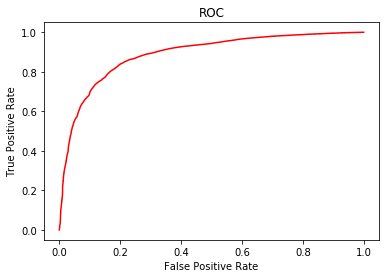

In [396]:
# plot ROC
plt.plot(fpr, tpr, color='red')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

plt.show()

## XGBoosting

### Train the model

In [ ]:
xgb = XGBClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [100,200,300],
              'learning_rate':[0.1, 0.3, 0.5],
              'max_depth': [3, 10, 15]
             }

# Run the grid search
grid_xgb = GridSearchCV(xgb, parameters,
                        cv=5, #Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_xgb = grid_xgb.fit(X_train, y_train)

# Set the xgb to the best combination of parameters
xgb = grid_xgb.best_estimator_

# Fit the best algorithm to the data. 
xgb.fit(X_train, y_train)

In [398]:
# make predictions
y_train_xgb = xgb.predict(X_train)
y_test_xgb = xgb.predict(X_test)

### Evaluate the model

In [411]:
print("Training set scores:")
print_results(y_train, y_train_xgb)

Training set scores:
Accuracy of the model is: 0.8612874934222067
Precision of the model is: 0.875240589907333
Recall of the model is: 0.9192935128224009
f1-score of the model is: 0.8967263372000013


In [412]:
print("Testing set scores:")
print_results(y_test, y_test_xgb)

Testing set scores:
Accuracy of the model is: 0.8436516080371159
Precision of the model is: 0.8630946291560102
Recall of the model is: 0.904563425584668
f1-score of the model is: 0.8833426038019828


In [413]:
print("AUC for train set is: {}".format(roc_auc_score(y_train, y_train_xgb)))

AUC for train set is: 0.8352045863731854


In [414]:
print("AUC for test set is: {}".format(roc_auc_score(y_test, y_test_xgb)))

AUC for test set is: 0.8164394552680991


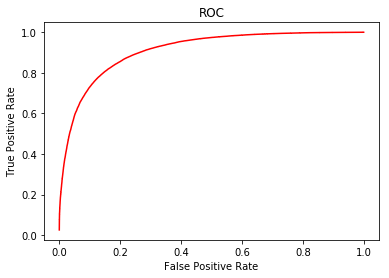

In [403]:
# plot ROC
y_test_xgb_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_xgb_proba)
# plot TPR against FPR
plt.plot(fpr, tpr, color='red')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

plt.show()

### Feature Importance

In [404]:
selected_features

['p1_play_freq',
 'p1_song_num',
 'p1_play_time',
 'p1_play_perc',
 'p1_down_freq',
 'p2_play_freq',
 'p2_song_num',
 'p2_play_time',
 'p2_play_perc',
 'p2_down_freq',
 'p3_play_freq',
 'p3_song_num',
 'p3_play_time',
 'p3_play_perc',
 'p3_down_freq',
 'recency']

Feature ranking:
1. feature 2 (0.203237)
2. feature 3 (0.195899)
3. feature 1 (0.110498)
4. feature 8 (0.087719)
5. feature 7 (0.081349)
6. feature 12 (0.076802)
7. feature 13 (0.074979)
8. feature 15 (0.056431)
9. feature 6 (0.050849)
10. feature 11 (0.041485)
11. feature 4 (0.016972)
12. feature 0 (0.001643)
13. feature 5 (0.001598)
14. feature 10 (0.000540)
15. feature 14 (0.000000)
16. feature 9 (0.000000)


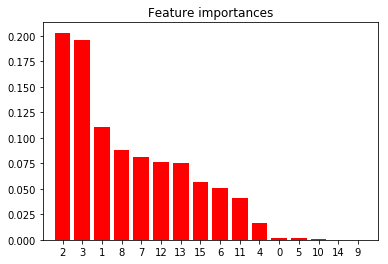

In [406]:
importances_xgb =xgb.feature_importances_

indices_xgb = np.argsort(importances_xgb)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_xgb[f], importances_xgb[indices_xgb[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_xgb[indices_xgb],
       color="r")
plt.xticks(range(X.shape[1]), indices_xgb)
plt.xlim([-1, X.shape[1]])
plt.show()

We can see for the xgboost model, the top three important features are p1_play_time,p1_play_perc and p1_song_num.

## Random Forest

### Train the model

In [408]:
# Choose the type of classifier. 
RFR = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [100,150,200],
              'min_samples_leaf': [3,5,8]
             }

# Run the grid search
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, #Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 38.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [415]:
# make predictions
y_train_rf = RFR.predict(X_train)
y_test_rf = RFR.predict(X_test)

### Evaluate the model

In [416]:
print("Training set scores:")
print_results(y_train, y_train_rf)

Training set scores:
Accuracy of the model is: 0.8801920715663919
Precision of the model is: 0.8876218602140294
Recall of the model is: 0.9355599884862806
f1-score of the model is: 0.910960689866446


In [417]:
print("Testing set scores:")
print_results(y_test, y_test_rf)

Testing set scores:
Accuracy of the model is: 0.8438884065216057
Precision of the model is: 0.8640446990375866
Recall of the model is: 0.9036252764189506
f1-score of the model is: 0.8833918557727582


In [418]:
print("AUC for train set is: {}".format(roc_auc_score(y_train, y_train_rf)))

AUC for train set is: 0.8552954100569046


In [419]:
print("AUC for test set is: {}".format(roc_auc_score(y_test, y_test_rf)))

AUC for test set is: 0.8172011577242699


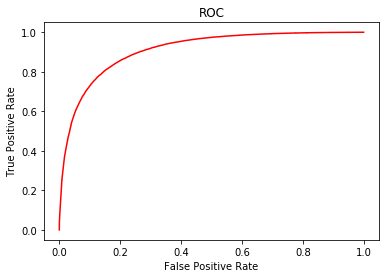

In [420]:
y_test_rf_proba = RFR.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_rf_proba)
# plot TPR against FPR
plt.plot(fpr, tpr, color='red')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

plt.show()

### Feature Importance

Feature ranking:
1. feature 15 (0.272664)
2. feature 10 (0.164425)
3. feature 13 (0.135531)
4. feature 11 (0.115516)
5. feature 12 (0.085874)
6. feature 6 (0.060335)
7. feature 5 (0.035846)
8. feature 8 (0.030464)
9. feature 2 (0.029928)
10. feature 1 (0.028435)
11. feature 7 (0.022557)
12. feature 3 (0.004937)
13. feature 9 (0.003945)
14. feature 4 (0.003332)
15. feature 14 (0.003318)
16. feature 0 (0.002895)


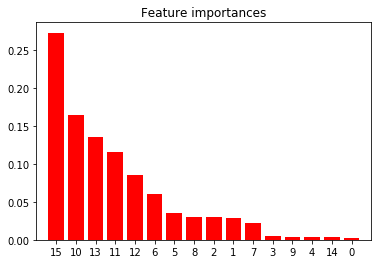

In [421]:
importances_rf = RFR.feature_importances_

indices_rf = np.argsort(importances_rf)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_rf[f], importances_rf[indices_rf[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_rf[indices_rf],
       color="r")
plt.xticks(range(X.shape[1]), indices_rf)
plt.xlim([-1, X.shape[1]])
plt.show()

We can see for the random forest model, the top three important features are recency, p3_play_freq and p3_play_perc.